In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
#R code 5.1
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';', header=0)
d['age_norm'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['divorce_norm'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()
d['marriage_norm'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()

In [3]:
#R code 5.2
d.MedianAgeMarriage.std()

1.243630301388082

In [4]:
#R code 5.3 (out of order intentionally)
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_age*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_1 = pm.sample(1000, tune=1000, chains=1) 
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1444.38it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
varnames = ['alpha','beta_age','sigma']
pm.summary(trace_5_1, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.00,0.10,0.0,-0.17,0.15
beta_age,-0.57,0.12,0.0,-0.75,-0.39
sigma,0.82,0.09,0.0,0.69,0.96


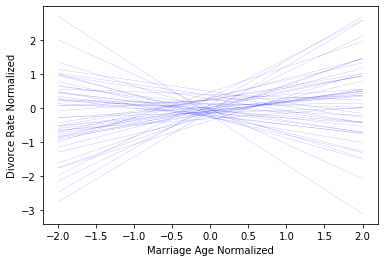

In [6]:
#R code 5.4. There are probably better ways to do this.
x = np.linspace(-2, 2, 100)
z=0
while z < 50:
    plt.plot(x, prior['alpha'][z] + prior['beta_age'][z]*x, linewidth=0.1, color='b')
    z+=1
plt.xlabel('Marriage Age Normalized')
plt.ylabel('Divorce Rate Normalized');

#The graph below shows that the priors we chose were bad. The standard deviation of the median age of marriage (not
#normalized) is 1.2 (R code 5.2). So, when the normalized marriage age is 1.0 (corresponding to an increase of age)
#of 1.2 years, our priors permit an increase in divorce rate by one full standard deviation.

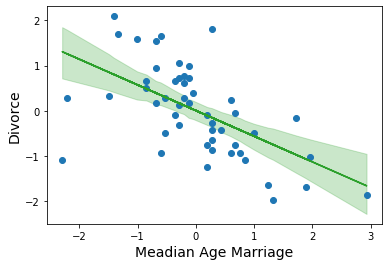

In [7]:
#R code 5.5, figure 5.2 (right)

mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.age_norm, d.divorce_norm, 'C0o')
plt.plot(d.age_norm, mu_mean.mean(0), 'C2')

idx = np.argsort(d.age_norm)
plt.fill_between(d.age_norm[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2082.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


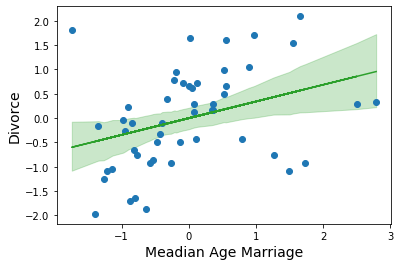

In [8]:
#R code 5.6, figure 5.2 (left)
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_marriage*d.marriage_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_2 = pm.sample(1000, tune=1000, chains=1) 
    #prior = pm.sample_prior_predictive()
    
mu_mean_marriage = trace_5_2['mu']
mu_hpd_marriage = pm.hpd(mu_mean_marriage)

plt.plot(d.marriage_norm, d.divorce_norm, 'C0o')
plt.plot(d.marriage_norm, mu_mean_marriage.mean(0), 'C2')

idx = np.argsort(d.marriage_norm)
plt.fill_between(d.marriage_norm[idx],
                 mu_hpd_marriage[:,0][idx], mu_hpd_marriage[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

In [9]:
varnames = ['alpha', 'beta_marriage', 'sigma']
pm.summary(trace_5_2, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,-0.00,0.11,0.0,-0.18,0.18
beta_marriage,0.34,0.13,0.0,0.13,0.56
sigma,0.95,0.10,0.0,0.80,1.10


C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


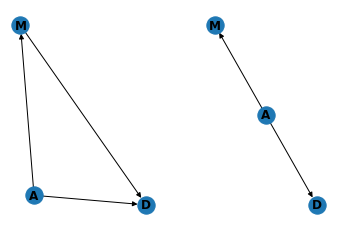

In [10]:
#Practicing making graphs

G1=nx.DiGraph()
G2=nx.DiGraph()
G1.add_edges_from([("A", "M"), ("A", "D"), ("M", "D")])
G2.add_edges_from([("A", "M"), ("A", "D")])
plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.show();

In [73]:
#R code 5.8
with pm.Model() as m_5_3:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=0.5) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_marriage*d.marriage_norm + beta_age*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_3 = pm.sample(1000, tune=1000, chains=1) 
    #prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, beta_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1212.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [12]:
varnames = ['alpha', 'beta_marriage', 'beta_age', 'sigma'] 
pm.summary(trace_5_3, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.00,0.10,0.00,-0.14,0.16
beta_marriage,-0.06,0.16,0.01,-0.32,0.18
beta_age,-0.61,0.16,0.01,-0.86,-0.35
sigma,0.83,0.09,0.00,0.69,0.96


C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\arviz\plots\forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\arviz\plots\forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


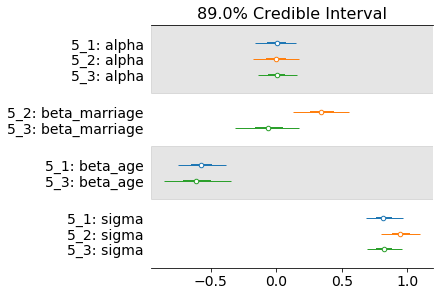

In [13]:
#R code 5.9
pm.forestplot((trace_5_1, trace_5_2, trace_5_3), model_names = ("5_1","5_2","5_3"), 
              var_names=varnames, credible_interval=0.89, linewidth=1, figsize=(6,4));

In [14]:
#R code 5.11
with pm.Model() as m_5_4:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_age_marriage = pm.Normal('beta_age_marriage', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_age_marriage*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    marriage = pm.Normal('marriage', mu=mu, sd=sigma, observed=d.marriage_norm)
    trace_5_4 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2067.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [41]:
#R code 5.12
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.marriage_norm - mu_pred

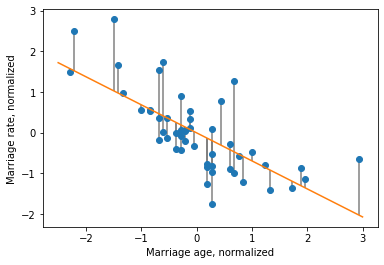

In [50]:
xvals1 = np.linspace(-2.5, 3)
plt.plot(d.age_norm, d.marriage_norm, 'o')
plt.plot(xvals1, trace_5_4['alpha'].mean() + trace_5_4['beta_age_marriage'].mean()*xvals1)
plt.vlines(d.age_norm, mu_pred, mu_pred + residuals, colors='grey')
plt.xlabel('Marriage age, normalized')
plt.ylabel('Marriage rate, normalized');

In [56]:
trace_5_3[1]

{'alpha': -0.02973743787705274,
 'beta_marriage': 0.02662916230875511,
 'beta_age': -0.37526731448526823,
 'sigma_log__': -0.11555584065001584,
 'mu': array([ 0.19838619,  0.26922827,  0.04821159,  0.54360924, -0.26195376,
         0.10082367, -0.51737804, -0.1735573 , -1.14684928, -0.15597739,
         0.03065721, -0.25146198,  0.87132897, -0.33071791,  0.07488097,
         0.17732604,  0.30223356,  0.36328502,  0.0201399 , -0.18051778,
        -0.41843874, -0.7980694 , -0.15948316, -0.13772186,  0.04120005,
         0.09664228,  0.06576597,  0.16400411, -0.27878145, -0.56367973,
         0.04891274, -0.76088271,  0.07908789,  0.24396119, -0.12650339,
         0.49520408, -0.02195487, -0.37772075, -0.71315318, -0.1482647 ,
         0.10715958,  0.22295211,  0.23767634,  0.86779767, -0.31106007,
        -0.131437  ,  0.02574913,  0.30293472, -0.12439993,  0.603934  ]),
 'sigma': 0.8908708240422106}

In [74]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred, alpha = 0.05)  #95% interval for mu values from model 5_3

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, 
                             model=m_5_3)['divorce'] #sampling divorce rates from the posterior
divorce_hpd = pm.hpd(divorce_pred)

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1494.25it/s]


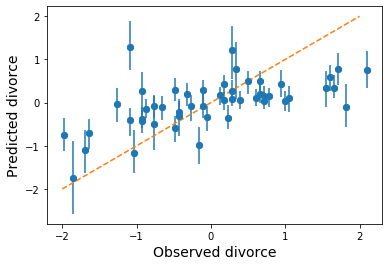

In [95]:
equality = np.linspace(-2,2,100)

plt.errorbar(d.divorce_norm, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.divorce_norm, divorce_pred.mean(0), 'o')
plt.plot(equality, equality, '--') #dashed line is just y=x, showing when predicted divorce rate = observed divorce rate

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14);


In [107]:
#R code 5.18
d = pd.read_csv('Data/milk.csv', sep=';', header=0)
d['k_s'] = (d['kcal.per.g'] - d['kcal.per.g'].mean())/d['kcal.per.g'].std()
d['n_s'] = (d['neocortex.perc'] - d['neocortex.perc'].mean())/d['neocortex.perc'].std()
d['m_s'] = (d.mass - d.mass.mean())/d.mass.std()

In [108]:
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,k_s,n_s,m_s
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,NaN,-0.510160
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,NaN,-0.493204
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,NaN,-0.529134
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,NaN,-0.506123


In [110]:
#R code 5.22 - we tried the code below with dataframe d, but got an error because of the NaN values.
#So we're dropping them.
dcc = d.dropna().copy()

In [113]:
#R code 5.23
with pm.Model() as m_5_5_draft:
    alpha = pm.Normal('alpha', mu=0, sd=1) 
    beta_N = pm.Normal('beta_N', mu=0, sd=1) 
    mu = pm.Deterministic('mu', alpha + beta_N*dcc.n_s)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('kcalpg', mu=mu, sd=sigma, observed=dcc.k_s)
    trace_5_5_draft = pm.sample(1000, tune=1000, chains=1) 
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_N, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1909.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [120]:
prior

{'mu': array([[ 0.1619143 ,  0.32216624,  0.32216624, ...,  0.41954749,
          0.52307913,  0.50924075],
        [ 1.7516294 ,  1.01353369,  1.01353369, ...,  0.5650107 ,
          0.08815995,  0.15189743],
        [ 0.00521568,  0.13150031,  0.13150031, ...,  0.20824043,
          0.2898273 ,  0.27892213],
        ...,
        [ 4.67000757,  1.75058656,  1.75058656, ..., -0.02347525,
         -1.90958307, -1.65747955],
        [ 3.94342629,  2.94202953,  2.94202953, ...,  2.33350484,
          1.68654702,  1.77302158],
        [ 1.80648828, -0.56339699, -0.56339699, ..., -2.00351917,
         -3.53459643, -3.32994749]]),
 'sigma': array([1.52662741e+00, 1.96919655e-01, 1.58170420e+00, 8.80671731e-01,
        6.80881815e-02, 8.28855612e-01, 1.46659435e+00, 1.68793448e+00,
        1.61958613e-01, 4.95534318e-02, 6.04455702e-01, 9.69484272e-01,
        1.72408603e-01, 2.14696040e+00, 2.24472583e-02, 2.72385936e+00,
        2.56609750e-01, 1.44606130e-01, 9.69401073e-01, 3.82627594e+00

In [123]:
prior['beta_N'].shape

(500,)

In [124]:
prior['alpha'][0]

0.3740325612563342

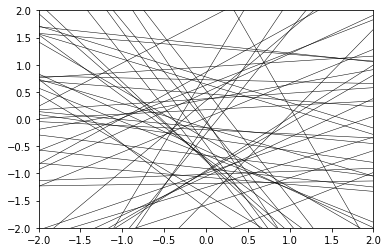

In [132]:
xvals = np.linspace(-2,2,50)
k=0
while k<50:
    plt.plot(xvals, prior['alpha'][k] + prior['beta_N'][k]*xvals, linewidth=0.5, color='k')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    k+=1

#these priors are crazy.